In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import markov_sim as markov
import json
import os
from datetime import datetime
from dateutil import parser
from hampel import hampel
import time
import copy
import preprocessing as p

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['HSA_OVERRIDE_GFX_VERSION'] = '10.3.0'
os.environ['LD_LIBRARY_PATH'] = '$LD_LIBRARY_PATH:/opt/rocm-5.3.0/lib'
data_list = []


   0-0  0-1  1-0  1-1  2-0  0-2  2-1  1-2  2-2  3-0  0-3       3-1       1-3  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.320627  0.186923   

        3-2       2-3   V1   V2    r1_win    r2_win  
0  0.266171  0.226279  0.0  0.0  0.586798  0.413202  


In [2]:
file = '1.145414064.json'

for line in open(file, 'r'):
    data_list.append(json.loads(line))

with open(file, 'r') as f:
    top = f.readline()
    top = json.loads(top)

runner_id = top['mc'][0]['marketDefinition']['runners'][0]['id']
runner_id_2 = top['mc'][0]['marketDefinition']['runners'][1]['id']
market_datetime = parser.parse(data_list[-1]['mc'][0]['marketDefinition']['marketTime'])
r1_result = data_list[-1]['mc'][0]['marketDefinition']['runners'][0]['status']
market_timestamp = datetime.timestamp(market_datetime) * 1000


def get_list(runner_id):
    # Create list for each runner
    runner_list = []
    for instance in data_list:
        if instance['pt'] > market_timestamp:
            if instance['mc'][0]['rc']:
                # Check for runner id
                temp_dict = {k: v for (k, v) in instance['mc'][0]['rc'][0].items() if v == runner_id}
                if temp_dict:
                    # Append runner info
                    runner_list.append([instance['mc'][0]['rc'][0], instance['pt']])
                elif len(instance['mc'][0]['rc']) > 1:
                    # If more than one runner
                    temp_dict_2 = {k: v for (k, v) in instance['mc'][0]['rc'][1].items() if v == runner_id}
                    if temp_dict_2:
                        runner_list.append([instance['mc'][0]['rc'][1], instance['pt']])
    return runner_list


def convert_odds(runner_list):
    # Convert to back/lay/last traded odds

    list = []

    for item in runner_list:
        if 'ltp' in item[0]:
            list.append([item[0]['ltp'], item[1]])

    del list[-1]
    arr = np.array(list)
    arr = arr[arr[:, 0] != 0]
    implied_odds = np.array([1 / arr[:, 0], arr[:, 1]]).T

    return implied_odds


# Find avg ltp odds
def odds_avg(runner_1, runner_2):
    if runner_1[-1, 1] > runner_2[-1, 1]:
        if runner_1[1, 1] > runner_2[1, 1]:
            timestamps = np.arange(round(runner_2[1, 1], -2), round(runner_1[-1, 1] + 1, -2), 100)
        else:
            timestamps = np.arange(round(runner_1[1, 1], -2), round(runner_1[-1, 1] + 1, -2), 100)
    else:
        if runner_1[1, 1] > runner_2[1, 1]:
            timestamps = np.arange(round(runner_2[1, 1], -2), round(runner_2[-1, 1] + 1, -2), 100)
        else:
            timestamps = np.arange(round(runner_1[1, 1], -2), round(runner_2[-1, 1] + 1, -2), 100)

    odds = np.zeros(np.shape(timestamps))
    df_timestamps = pd.Series(timestamps)

    df_datetime = pd.to_datetime(df_timestamps, unit='ms')

    df = pd.DataFrame({'runner 1': odds, '1 - runner 2': odds}, index=df_datetime)

    for index, time in enumerate(runner_1[:, 1]):
        df['runner 1'].loc[pd.to_datetime(round(time, -2), unit='ms')] = runner_1[index, 0]

    for index, time in enumerate(runner_2[:, 1]):
        df['1 - runner 2'].loc[pd.to_datetime(round(time, -2), unit='ms')] = 1 - runner_2[index, 0]

    df.replace(0, np.nan, inplace=True)
    df.interpolate(method='time', limit_direction='both', inplace=True)
    df['avg'] = df.mean(axis=1)
    df_avg_odds = df.resample('30000ms').last()
    last_index = df_avg_odds.last_valid_index() + pd.Timedelta(1, 'sec')
    final_index = last_index + pd.Timedelta(59, 'sec')
    df_datetime = pd.date_range(last_index, final_index, freq='30000ms')
    print(df_datetime)
    if r1_result == 'WINNER':
        df_ones = pd.DataFrame({'runner 1': np.ones(2), '1 - runner 2': np.ones(2), 'avg': np.ones(2)}, index=df_datetime)
        df_avg_odds = pd.concat([df_avg_odds, df_ones])
    else:
        df_zeros = pd.DataFrame({'runner 1': np.zeros(2), '1 - runner 2': np.zeros(2), 'avg': np.zeros(2)}, index=df_datetime)
        df_avg_odds = pd.concat([df_avg_odds, df_zeros])
    print(df_avg_odds)
    return df_avg_odds

def get_best_pricevol(runner_list, price, vol):
# Function to get best lay and back information
    back_list = []
    lay_list = []

    back_vol = []
    lay_vol = []

    for item in runner_list:
        if 'atl' in item[0]:
            if len(item[0]['atl']) > 1:
                temp = []
                for i in item[0]['atl']:
                    if i[1] != 0:
                        temp.append(i[0])
                if temp:
                    temp = np.array(temp)
                    back_list.append([temp.min(), item[1]])
                    back_vol.append([item[0]['atl'][temp.argmax()][1], item[1]])
            else:
                if item[0]['atl'][0][1] != 0:
                    back_list.append([item[0]['atl'][0][0], item[1]])
                    back_vol.append([item[0]['atl'][0][1], item[1]])

    for item in runner_list:
        if 'atb' in item[0]:
            if len(item[0]['atb']) > 1:
                temp = []
                for i in item[0]['atb']:
                    if i[1] != 0:
                        temp.append(i[0])
                if temp:
                    temp = np.array(temp)
                    lay_list.append([temp.max(), item[1]])
                    lay_vol.append([item[0]['atb'][temp.argmax()][1], item[1]])
            else:
                if item[0]['atb'][0][1] != 0:
                    lay_list.append([item[0]['atb'][0][0], item[1]])
                    lay_vol.append([item[0]['atb'][0][1], item[1]])

    del back_list[-1], lay_list[-1], back_vol[-1], lay_vol[-1]

    back_vol_arr = np.array(back_vol)
    lay_vol_arr = np.array(lay_vol)
    back_arr = np.array(back_list)
    lay_arr = np.array(lay_list)

    back_series = pd.Series(back_arr[:, 0], index=pd.to_datetime(back_arr[:, 1], unit='ms'))
    lay_series = pd.Series(lay_arr[:, 0], index=pd.to_datetime(lay_arr[:, 1], unit='ms'))
    back_vol_series = pd.Series(back_vol_arr[:, 0], index=pd.to_datetime(back_vol_arr[:, 1], unit='ms'))
    lay_vol_series = pd.Series(lay_vol_arr[:, 0], index=pd.to_datetime(lay_vol_arr[:, 1], unit='ms'))
# Apply hampel filter to remove outliers
    back_outliers = hampel(back_series, window_size=80)
    lay_outliers = hampel(lay_series, window_size=80)
    back_vol_outliers = hampel(back_vol_series, window_size=15)
    lay_vol_outliers = hampel(lay_vol_series, window_size=15)

    back_arr = np.delete(back_arr, back_outliers, axis=0)
    lay_arr = np.delete(lay_arr, lay_outliers, axis=0)
    back_vol_arr = np.delete(back_vol_arr, back_vol_outliers, axis=0)
    lay_vol_arr = np.delete(lay_vol_arr, lay_vol_outliers, axis=0)

    if price and not vol:
        return back_arr, lay_arr
    elif vol and not price:
        return back_vol_arr, lay_vol_arr

    return back_arr, lay_arr, back_vol_arr, lay_vol_arr

def best_available_df(runner_list, start, end):
# Get back and lay information and calculate spread and price up probability
    end_time = end + pd.Timedelta(120, 'sec')
    df_datetime = pd.date_range(start, end_time, freq='100ms')
    df_datetime = df_datetime.floor('100ms')
    dt_shape = np.zeros(df_datetime.shape)

    back_arr, lay_arr, back_vol_arr, lay_vol_arr = get_best_pricevol(runner_list, True, True)

    df = pd.DataFrame({'back': dt_shape, 'lay': dt_shape, 'back_vol': dt_shape, 'lay_vol': dt_shape}, index=df_datetime)

    for index, time in enumerate(back_arr[:, 1]):
        df['back'].loc[pd.to_datetime(round(time, -2), unit='ms')] = back_arr[index, 0]
    for index, time in enumerate(lay_arr[:, 1]):
        df['lay'].loc[pd.to_datetime(round(time, -2), unit='ms')] = lay_arr[index, 0]

    for index, time in enumerate(back_vol_arr[:, 1]):
        df['back_vol'].loc[pd.to_datetime(round(time, -2), unit='ms')] = back_vol_arr[index, 0]
    for index, time in enumerate(lay_vol_arr[:, 1]):
        df['lay_vol'].loc[pd.to_datetime(round(time, -2), unit='ms')] = lay_vol_arr[index, 0]

    df.replace(0, np.nan, inplace=True)
    df.interpolate(method='time', limit_direction='both', inplace=True)

    _30000ms = df.index.floor('30000ms')
    idx_back = df.groupby(_30000ms)['back'].idxmin()
    idx_lay = df.groupby(_30000ms)['lay'].idxmax()
    df = df.resample('30000ms').mean().assign(back=df.loc[idx_back]['back'].values,
                                            back_vol=df.loc[idx_back]['back_vol'].values,
                                            lay=df.loc[idx_lay]['lay'].values,
                                            lay_vol=df.loc[idx_lay]['lay_vol'].values)

    df_best = df.rolling('60S').mean()
    df_best = df_best.loc[start:end]
    # last_index = end + pd.Timedelta(1, 'sec')
    # final_index = last_index + pd.Timedelta(59, 'sec')
    # df_datetime_new = pd.date_range(last_index, final_index, freq='30000ms')
    # print(end, last_index)
    # if r1_result == 'WINNER':
    #     df_ones = pd.DataFrame({'back': np.repeat(1000, 60), 'back_vol': np.zeros(60), 'lay': np.repeat(1000, 60), 'lay_vol': np.repeat(0.001, 60)}, index=df_datetime_new)
    #     df_best = pd.concat([df_best, df_ones])
    # else:
    #     df_zeros = pd.DataFrame({'back': np.ones(60), 'back_vol': np.zeros(60), 'lay': np.ones(60), 'lay_vol': np.repeat(0.001, 60)}, index=df_datetime_new)
    #     df_best = pd.concat([df, df_zeros])
    df_best['back-lay avg'] = df_best[['back', 'lay']].mean(axis=1)
    df_best['spread'] = df_best['back'] - df_best['lay']
    df_best['vol diff'] = df_best['back_vol'] - df_best['lay_vol']
    df_best['uncertainty'] = df_best['spread'] / df_best['back-lay avg']
    df_pup = df_best['back_vol'] / ( df_best['back_vol'] + df_best['lay_vol'] )
    df_pup.name = 'pup'
    df_best = pd.concat([df_best, df_pup], axis=1)
    df_best.fillna(method='ffill', inplace=True)

    return df_best

def get_serve_prob(first_odds):
    df = pd.read_csv('markov_serve_prob.csv', index_col=0)
    difference = np.absolute(df.index.to_numpy() - first_odds)
    index = difference.argmin()
    r1 = df.iloc[index]
    r2 = 1.29 - r1
    return r1, r2

def get_score_time_series(p, q, df_odds, server):

    setscore = '0-0'
    gamescore = '0-0'

    odds_arr = df_odds.to_numpy()
    set_trans = markov.set_nextscore()
    match_trans = markov.match_nextscore()
    mis, sis, gis, tbis = initiate_markov_states()

    r1_gamescore = np.zeros(odds_arr.shape, dtype=int)
    r1_setscore = np.empty(odds_arr.shape, dtype=int)
    r2_gamescore = np.empty(odds_arr.shape, dtype=int)
    r2_setscore = np.empty(odds_arr.shape, dtype=int)

    for i, odds in enumerate(odds_arr):
        t1 = time.time()
        game_temp = gamescore
        setscore, gamescore, p, q = calc_score(p, q, setscore, gamescore, server, odds, set_trans, match_trans, mis, sis, gis, tbis)
        r1_gamescore[i] = gamescore.split('-')[0]
        r2_gamescore[i] = gamescore.split('-')[1]
        r1_setscore[i] = setscore.split('-')[0]
        r2_setscore[i] = setscore.split('-')[1]
        if r1_setscore[i] == 3 or r2_setscore[i] == 3:
            print('Match finished at ' + setscore)
            break
        if gamescore != game_temp:
            if server == 1:
                server = 0
            else:
                server = 1
        t2 = time.time()
        print(t2 - t1)

    df = pd.DataFrame({'r1_gs': r1_gamescore, 'r2_gs': r2_gamescore, 'r1_setscore': r1_setscore, 'r2_setscore': r2_setscore}, index=df_odds.index)
    df.iloc[i + 1:] = 0
    df.replace(to_replace=0, method='ffill', inplace=True)

    return df


def initiate_markov_states():
    matrix = np.zeros((1, 17))
    game_initial_state = pd.DataFrame(data=matrix, columns=markov.col_row_names)
    game_initial_state.at[0, "0-0"] = 1
    matrix = np.zeros((1, 54))
    tb_initial_state = pd.DataFrame(data=matrix, columns=markov.col_row_names2)
    tb_initial_state.at[0, "0-0"] = 1
    matrix = np.zeros((1, 41))
    set_initial_sate = pd.DataFrame(data=matrix, columns=markov.col_row_names3)
    set_initial_sate.at[0, "0-0"] = 1
    matrix = np.zeros((1, 17))
    match_initial_state = pd.DataFrame(data=matrix, columns=markov.col_row_names4)
    match_initial_state.at[0, "0-0"] = 1

    return match_initial_state, set_initial_sate, game_initial_state, tb_initial_state


def recal_pointprobs(odds, gamescore, setscore, server, p, q, mis, sis, gis, tbis):
    serve_temp = 0
    odds_temp = 0
    error_old = 1

    if server == 1:
        while abs(odds - odds_temp) <= error_old:
            t1 = time.time()
            mis1 = mis.copy()
            sis1 = sis.copy()
            gis1 = gis.copy()
            tbis1 = tbis.copy()
            error_old = abs(odds - odds_temp)
            odds_temp = markov.tennis_model(serve_temp, q, setscore, gamescore, mis1, sis1, gis1, tbis1)['r1_win'].values
            t2 = time.time()
        p = odds_temp
    else:
        while abs(odds - odds_temp) <= error_old:
            mis1 = mis.copy()
            sis1 = sis.copy()
            gis1 = gis.copy()
            tbis1 = tbis.copy()
            error_old = abs(odds - odds_temp)
            odds_temp = markov.tennis_model(p, serve_temp, setscore, gamescore, mis1, sis1, gis1, tbis1)['r1_win'].values
        q = odds_temp
    
    return p, q


def set_nextscore(set_transitions, score, winner):
    next_score = set_transitions.columns[(set_transitions == winner).loc[score]]
    return next_score[0]


def match_nextscore(match_transitions, score, winner):
    next_score = match_transitions.columns[(match_transitions == winner).loc[score]]
    return next_score[0]


def calc_score(p, q, setscore, gamescore, server, implied_odds, set_transitions, match_transitions, mis, sis, gis, tbis):

    nextsetv1 = set_nextscore(set_transitions, gamescore, 1)
    nextsetv2 = set_nextscore(set_transitions, gamescore, -1)
    nextmatchv1 = match_nextscore(match_transitions, setscore, 1)
    nextmatchv2 = match_nextscore(match_transitions, setscore, -1)

    if nextsetv1 == 'SETv1' and nextsetv2 == 'SETv2':
        nextsetv1 = '0-0'
        nextsetv2 = '0-0'
    elif nextsetv1 == 'SETv1':
        nextsetv1 = '0-0'
        nextmatchv2 = setscore
    elif nextsetv2 == 'SETv2':
        nextsetv2 = '0-0'
        nextmatchv1 = setscore
    else:
        nextmatchv1 = setscore
        nextmatchv2 = setscore

    mis1 = mis.copy()
    sis1 = sis.copy()
    gis1 = gis.copy()
    tbis1 = tbis.copy()
    mis2 = mis.copy()
    sis2 = sis.copy()
    gis2 = gis.copy()
    tbis2 = tbis.copy()

    if nextmatchv1 == ('3-2') and nextmatchv2 == ('2-3'):
        m1 = 1
        m2 = 0
    elif nextmatchv1 == '3-2' or nextmatchv1 == '3-1' or nextmatchv1 == '3-0':
        m1 = 1
        m2 = markov.tennis_model(p, q, nextmatchv2, nextsetv2, mis2, sis2, gis2, tbis2)['r1_win'].values
    elif nextmatchv2 == '2-3' or nextmatchv2 == '1-3' or nextmatchv2 == '0-3':
        m1 = markov.tennis_model(p, q, nextmatchv1, nextsetv1, mis1, sis1, gis1, tbis1)['r1_win'].values
        m2 = 0
    else:
        m1 = markov.tennis_model(p, q, nextmatchv1, nextsetv1, mis1, sis1, gis1, tbis1)['r1_win'].values
        m2 = markov.tennis_model(p, q, nextmatchv2, nextsetv2, mis2, sis2, gis2, tbis2)['r1_win'].values

    if implied_odds >= m1:
        gamescore = nextsetv1
        setscore = nextmatchv1
    elif implied_odds <= m2:
        gamescore = nextsetv2
        setscore = nextmatchv2

    if gamescore != '6-6':
        p, q = recal_pointprobs(implied_odds, gamescore, setscore, server, p, q, mis, sis, gis, tbis)

    return setscore, gamescore, p, q



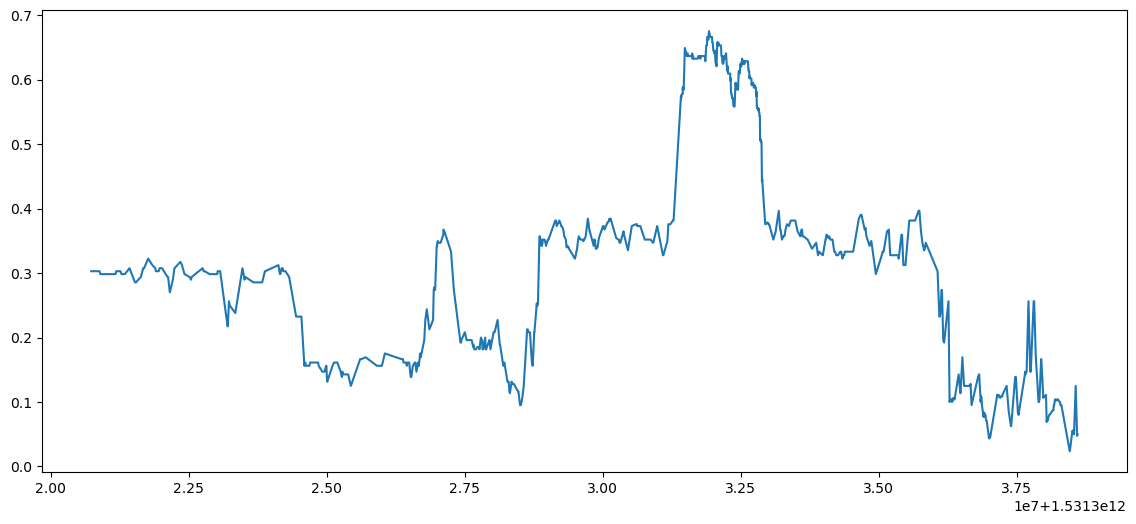

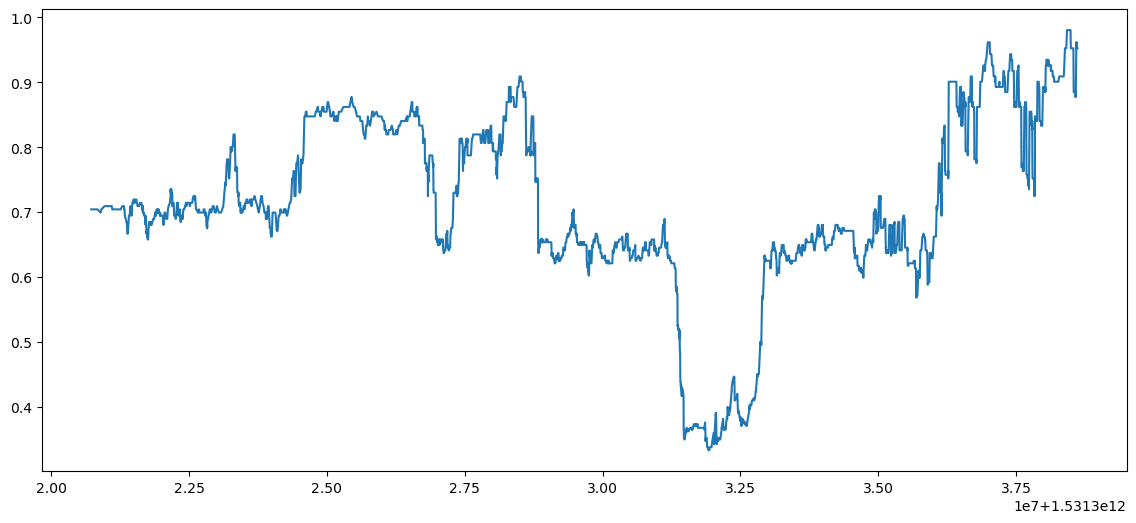

In [3]:
runner_list_1 = get_list(runner_id)
runner_list_2 = get_list(runner_id_2)
runner_odds_1 = convert_odds(runner_list_1)
runner_odds_2 = convert_odds(runner_list_2)
plt.figure(figsize=(14,6))
plt.plot(runner_odds_1[:, 1], runner_odds_1[:, 0])
plt.figure(figsize=(14,6))
plt.plot(runner_odds_2[:, 1], runner_odds_2[:, 0])


In [4]:
df = odds_avg(runner_odds_1, runner_odds_2)

DatetimeIndex(['2018-07-11 19:50:01', '2018-07-11 19:50:31'], dtype='datetime64[ns]', freq='30000L')
                     runner 1  1 - runner 2       avg
2018-07-11 14:52:00  0.303030      0.295775  0.299402
2018-07-11 14:52:30  0.303030      0.295775  0.299402
2018-07-11 14:53:00  0.303030      0.295775  0.299402
2018-07-11 14:53:30  0.303030      0.295801  0.299416
2018-07-11 14:54:00  0.303030      0.298458  0.300744
...                       ...           ...       ...
2018-07-11 19:49:00  0.119696      0.115044  0.117370
2018-07-11 19:49:30  0.049708      0.045093  0.047401
2018-07-11 19:50:00  0.050000      0.047619  0.048810
2018-07-11 19:50:01  0.000000      0.000000  0.000000
2018-07-11 19:50:31  0.000000      0.000000  0.000000

[599 rows x 3 columns]


0.24586293764327782
Serve percentage    0.623
Name: 0.2451023611503342, dtype: float64
Serve percentage    0.667
Name: 0.2451023611503342, dtype: float64


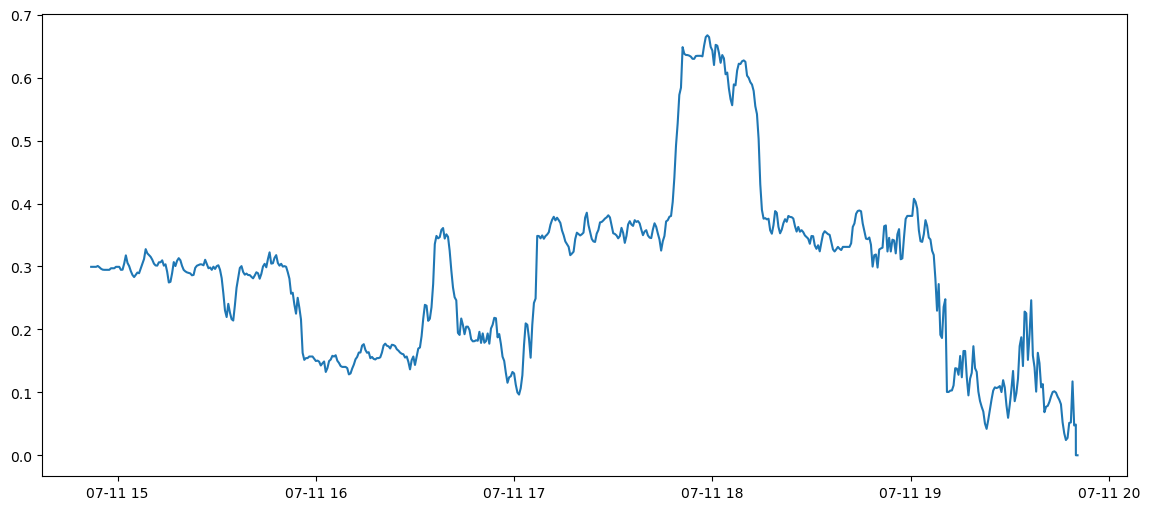

In [5]:
plt.figure(figsize=(14,6))
plt.plot(df['avg'])
first_odds = df['avg'].iloc[0:300].mean()
print(first_odds)
r1, r2 = get_serve_prob(first_odds)
print(r1)
print(r2)

In [7]:
df_score = get_score_time_series(r1, r2, df['avg'], 0)

0.07058572769165039


KeyboardInterrupt: 

In [7]:
df_score

,r1_gs,r2_gs,r1_setscore,r2_setscore
2018-07-11 16:36:42,0,0,0,0
2018-07-11 16:36:44,0,0,0,0
2018-07-11 16:36:46,0,0,0,0
2018-07-11 16:36:48,0,0,0,0
2018-07-11 16:36:50,0,0,0,0
...,...,...,...,...
2018-07-11 19:27:53,1,5,1,3
2018-07-11 19:27:55,1,5,1,3
2018-07-11 19:27:57,1,5,1,3
2018-07-11 19:27:59,1,5,1,3


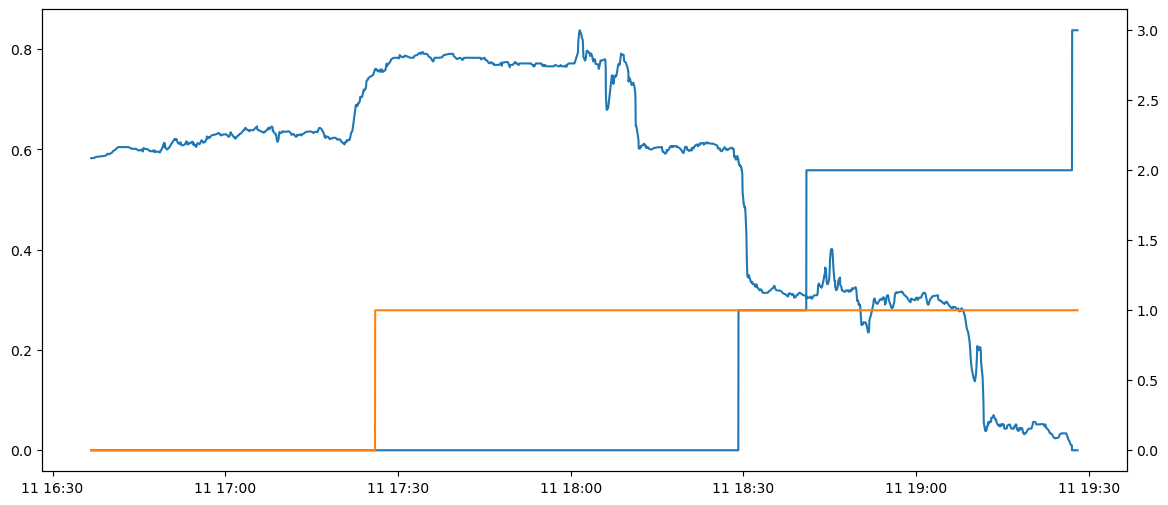

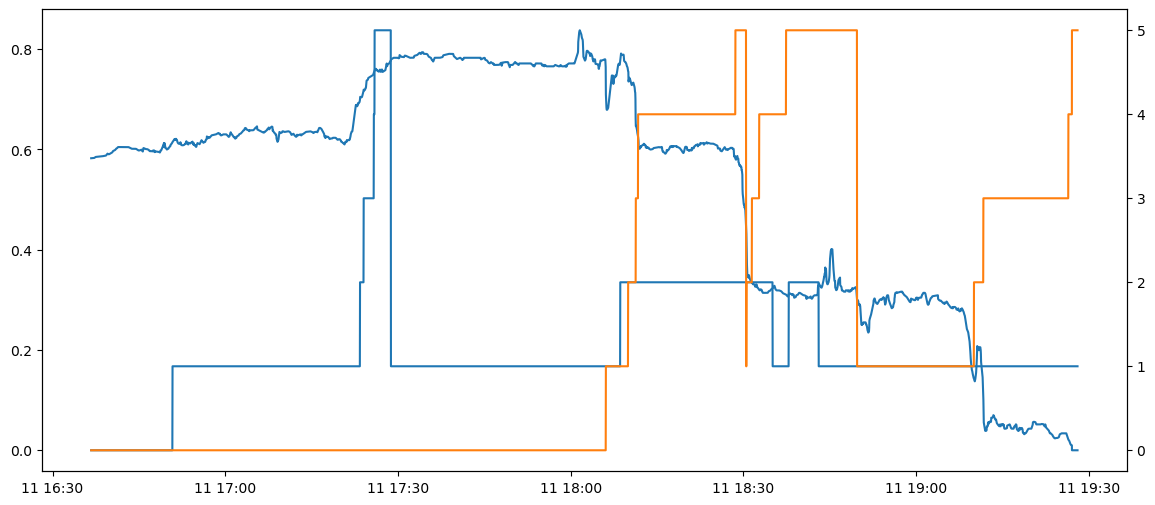

In [9]:
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(df['avg'])
ax2 = ax.twinx()
ax2.plot(df_score['r2_setscore'])
ax2.plot(df_score['r1_setscore'])
fig, ax1 = plt.subplots(figsize=(14,6))
ax1.plot(df['avg'])
ax3 = ax1.twinx()
ax3.plot(df_score['r1_gs'])
ax3.plot(df_score['r2_gs'])

In [19]:
start = df.first_valid_index()
end = df.last_valid_index()
df_runner_1 = best_available_df(runner_list_1, start, end)
df_runner_1

,back,lay,back_vol,lay_vol,back-lay avg,spread,vol diff,uncertainty,pup
2018-07-11 14:52:06,3.500000,3.250000,454.270000,1286.340000,3.375000,0.250000,-832.070000,0.074074,0.260983
2018-07-11 14:52:08,3.493092,3.250000,454.220039,1286.340000,3.371546,0.243092,-832.119961,0.072101,0.260962
2018-07-11 14:52:10,3.477632,3.250000,454.098698,1286.340000,3.363816,0.227632,-832.241302,0.067671,0.260910
2018-07-11 14:52:12,3.460033,3.250000,453.959512,1286.340000,3.355016,0.210033,-832.380488,0.062603,0.260851
2018-07-11 14:52:14,3.441579,3.250000,453.813188,1286.340000,3.345789,0.191579,-832.526812,0.057260,0.260789
...,...,...,...,...,...,...,...,...,...
2018-07-11 19:51:04,8.800000,8.389333,5.439049,4.973467,8.594667,0.410667,0.465582,0.047782,0.522357
2018-07-11 19:51:06,8.800000,8.398000,4.915382,4.995025,8.599000,0.402000,-0.079643,0.046750,0.495982
2018-07-11 19:51:08,8.800000,8.400000,4.475257,5.000000,8.600000,0.400000,-0.524743,0.046512,0.472310
2018-07-11 19:51:10,8.800000,8.400000,4.509640,5.000000,8.600000,0.400000,-0.490360,0.046512,0.474218


In [20]:
df_runner_2 = best_available_df(runner_list_2, start, end)
df_runner_2

,back,lay,back_vol,lay_vol,back-lay avg,spread,vol diff,uncertainty,pup
2018-07-11 14:52:06,1.460000,1.406364,4770.900000,11552.636667,1.433182,0.053636,-6781.736667,0.037425,0.292271
2018-07-11 14:52:08,1.460000,1.413182,4770.900000,14378.233333,1.436591,0.046818,-9607.333333,0.032590,0.249144
2018-07-11 14:52:10,1.453333,1.405455,4770.744294,10981.494298,1.429394,0.047879,-6210.750004,0.033496,0.302861
2018-07-11 14:52:12,1.450000,1.401591,4770.531695,9282.935157,1.425795,0.048409,-4512.403462,0.033952,0.339456
2018-07-11 14:52:14,1.450167,1.401390,4770.260407,9148.384243,1.425779,0.048776,-4378.123837,0.034210,0.342724
...,...,...,...,...,...,...,...,...,...
2018-07-11 19:51:04,1.050000,1.042000,17589.575394,630.145085,1.046000,0.008000,16959.430310,0.007648,0.965414
2018-07-11 19:51:06,1.050000,1.041667,17554.861283,583.881569,1.045833,0.008333,16970.979714,0.007968,0.967810
2018-07-11 19:51:08,1.050000,1.041333,17244.502505,550.631736,1.045667,0.008667,16693.870769,0.008288,0.969057
2018-07-11 19:51:10,1.050000,1.041000,13724.510728,539.378944,1.045500,0.009000,13185.131783,0.008608,0.962186


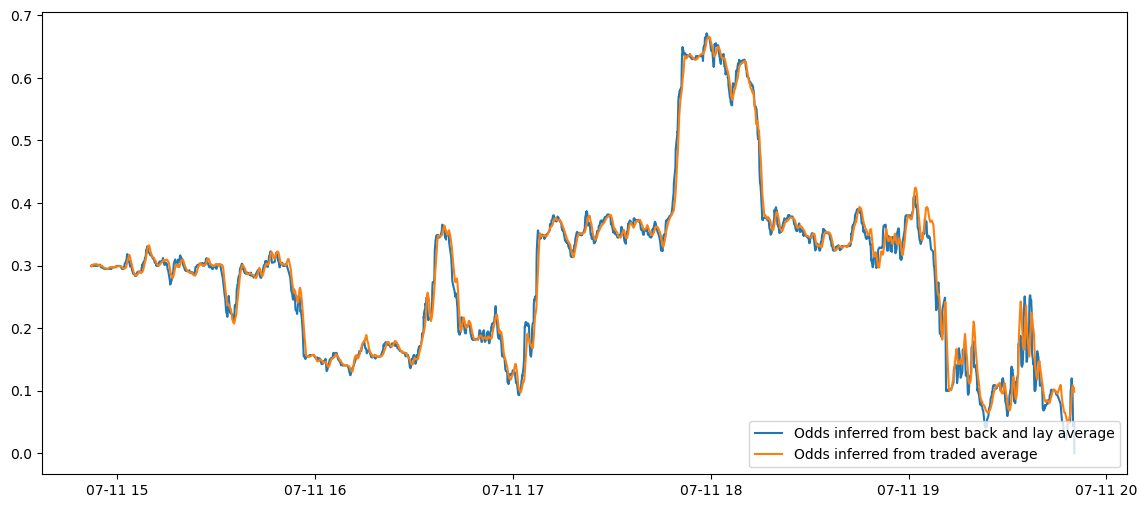

In [21]:
df_avg = df['avg']
df_blodds = ( 1 / df_runner_1['back-lay avg'] + 1 - 1 / df_runner_2['back-lay avg'] ) / 2
df_odds = pd.concat([df_avg, df_blodds], axis=1)
df_odds.columns = ['ltp odds', 'back lay odds']
df_odds
plt.figure(figsize=(14,6))
plt.plot(df_odds)
plt.legend(['Odds inferred from best back and lay average', 'Odds inferred from traded average'], loc='lower right')

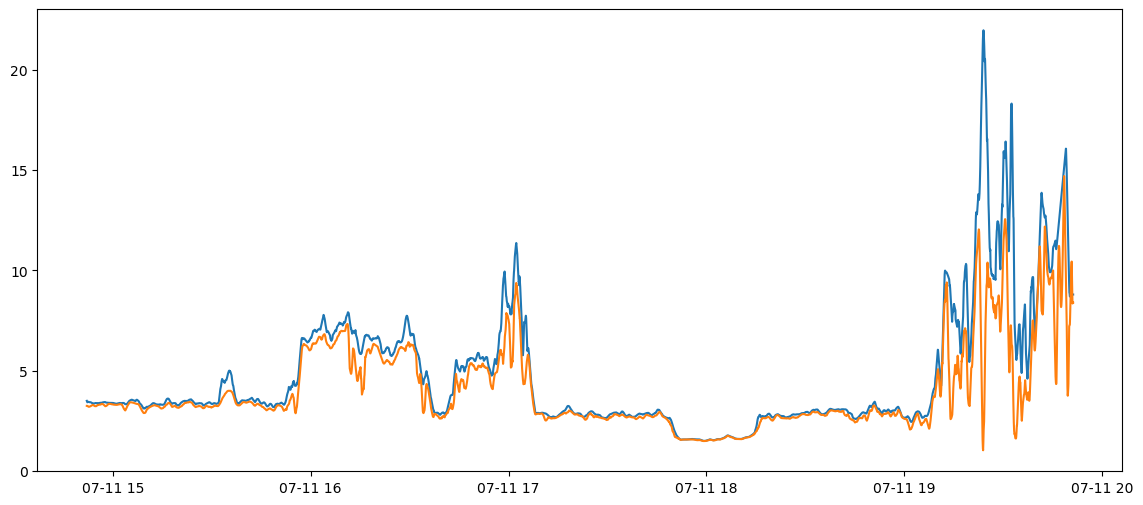

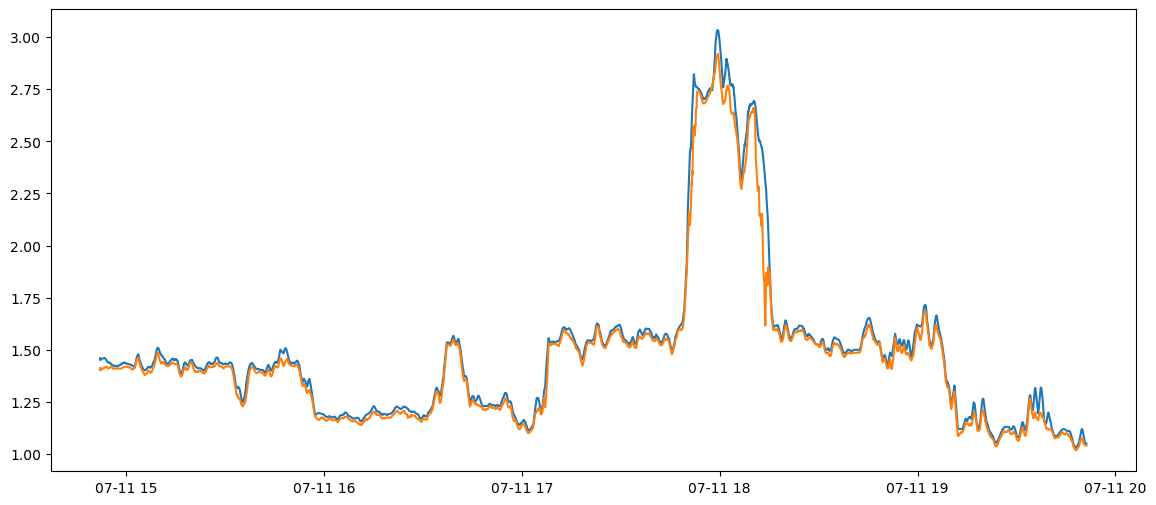

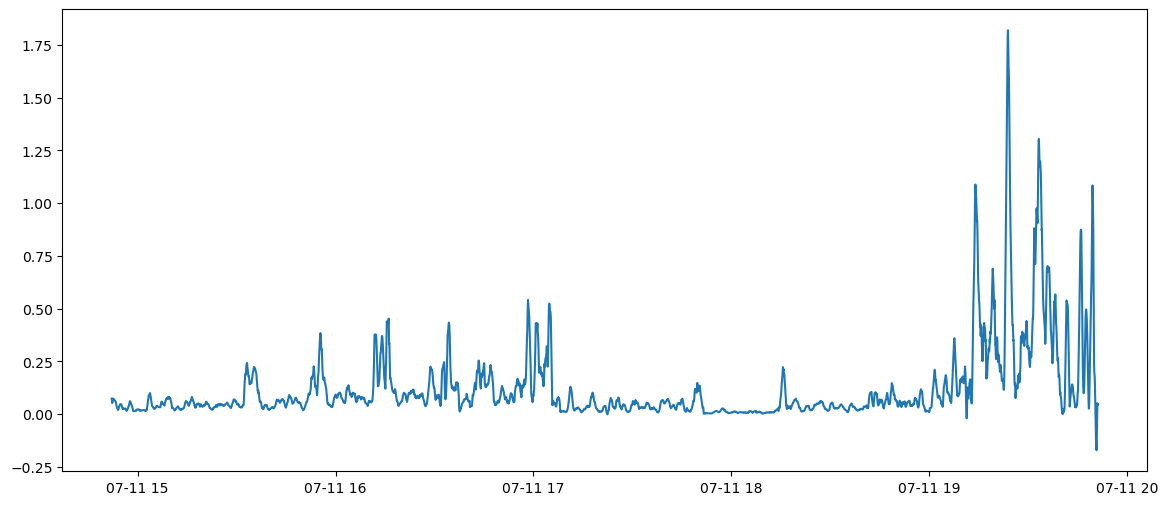

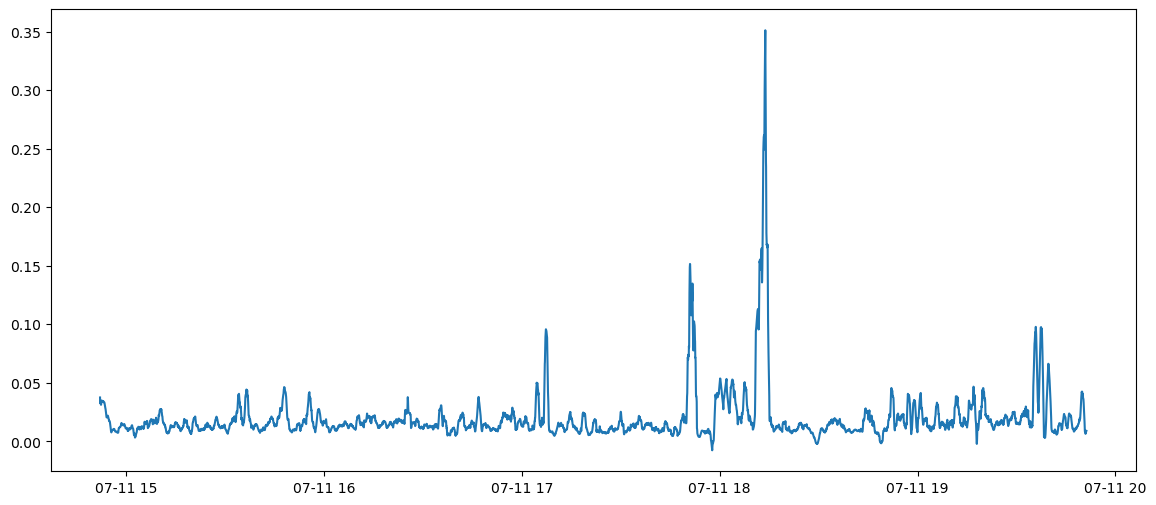

In [23]:
plt.figure(figsize=(14,6))
plt.plot(df_runner_1[['back','lay']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_2[['back','lay']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_1[['uncertainty']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_2[['uncertainty']])

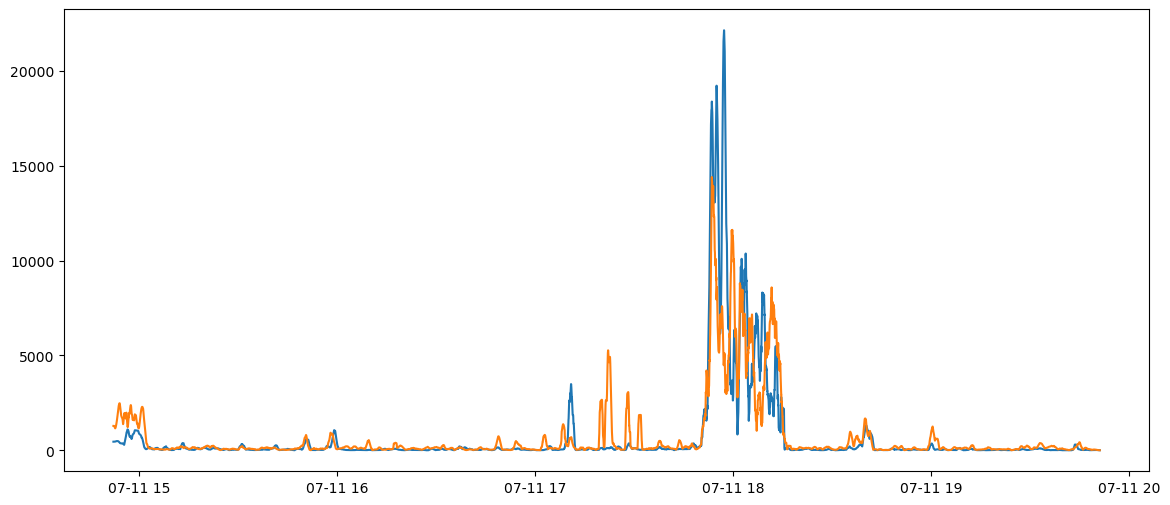

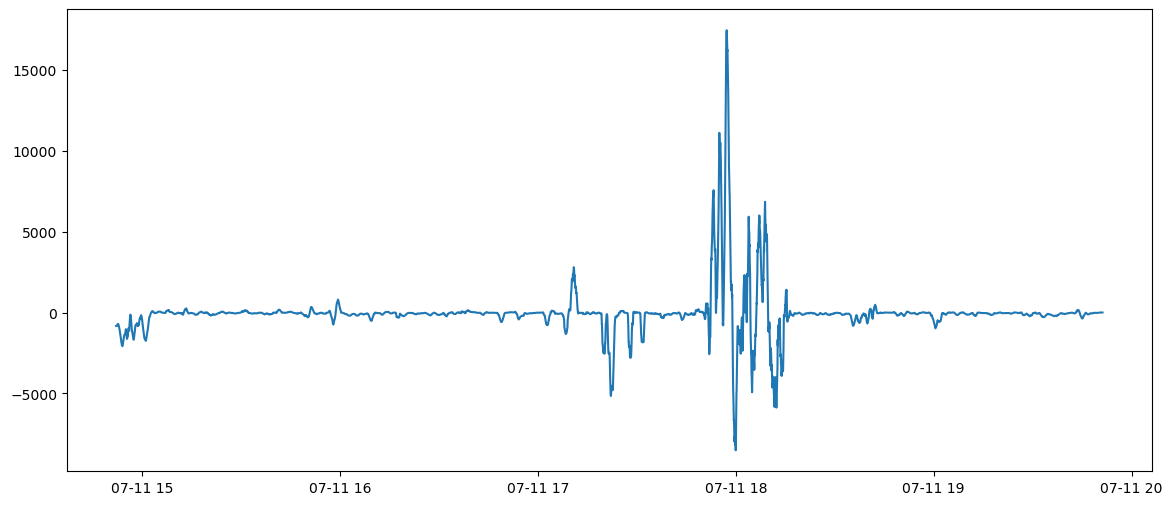

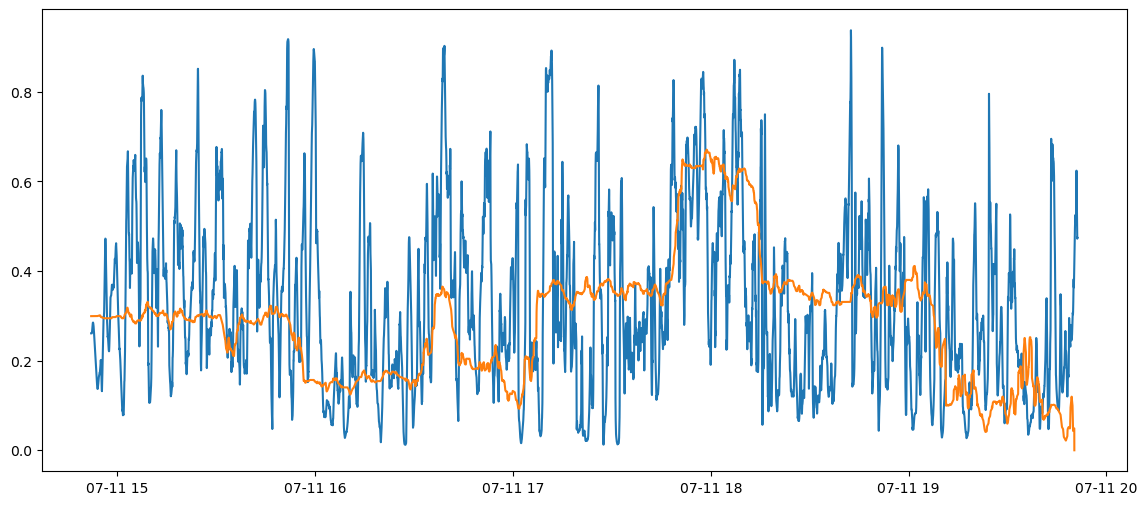

In [24]:
plt.figure(figsize=(14,6))
plt.plot(df_runner_1[['back_vol']])
plt.plot(df_runner_1[['lay_vol']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_1[['vol diff']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_1[['pup']])
plt.plot(df_odds['ltp odds'])

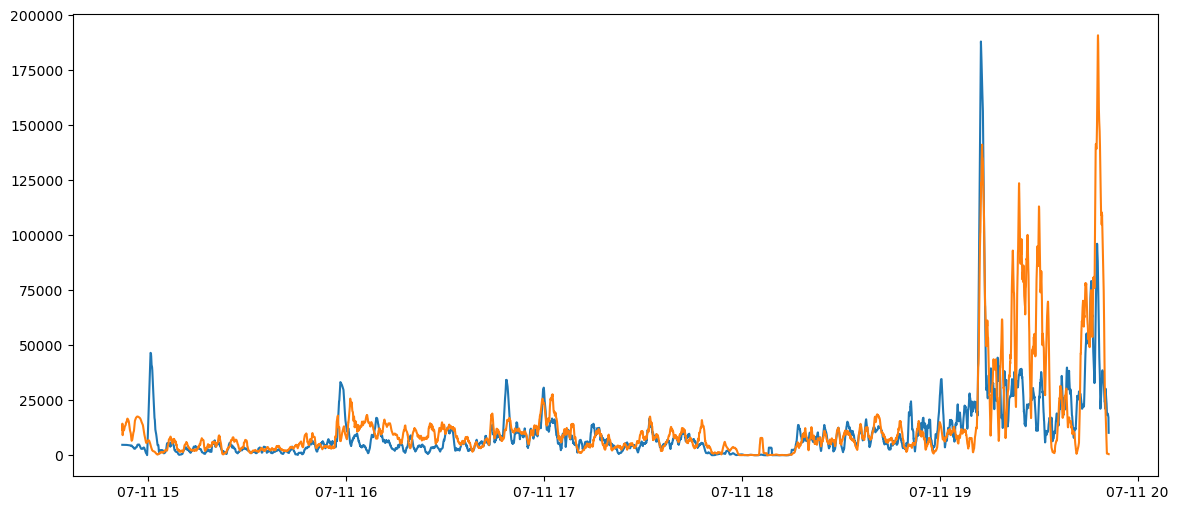

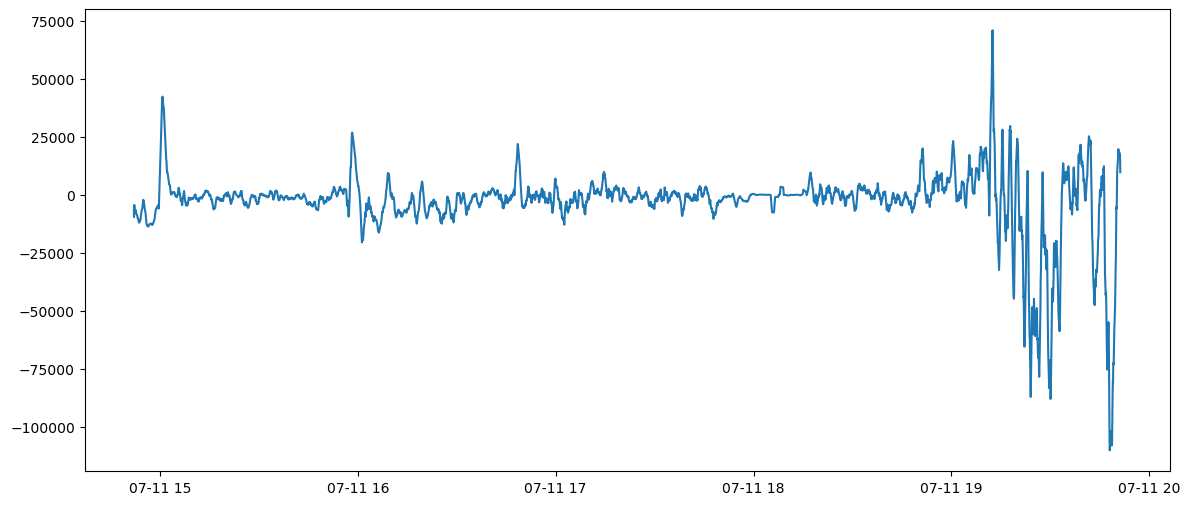

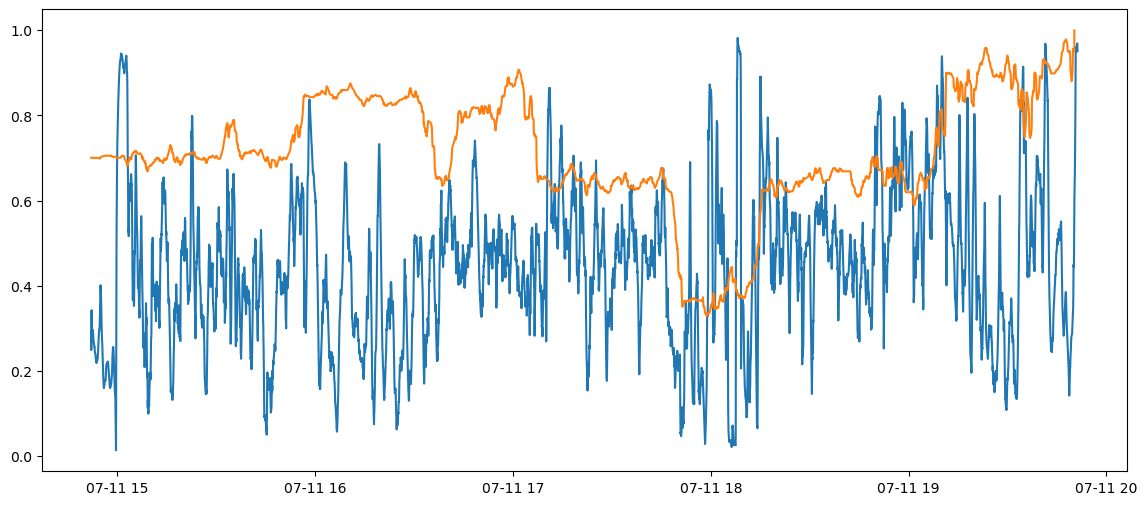

In [25]:
plt.figure(figsize=(14,6))
plt.plot(df_runner_2[['back_vol']])
plt.plot(df_runner_2[['lay_vol']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_2[['vol diff']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_2[['pup']])
plt.plot(1 - df_odds['ltp odds'])
df_total = pd.DataFrame({'lpt odds': df_odds['ltp odds'], 'r1 spread': df_runner_1['uncertainty'], 'r1 pup': df_runner_1['pup'], 'r2 spread': df_runner_2['uncertainty'], 'r2 pup': df_runner_2['pup']}, index=df_odds.index)
df_total
df_total.to_csv('Data/1.csv')